In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from scipy.io import arff
from collections import Counter



## Part A: Preprocessing and Initial Setup
First, I need to prepare the data for visualization. This involves loading the dataset, understanding its dimensions, simplifying the labels for clear plotting, and scaling the features to ensure fairness in our distance-based algorithms

In [41]:
# Set style for plots
sns.set(style="whitegrid", context="notebook", rc={"figure.figsize": (10, 8)})

# --- 1. Data Loading ---
# Load the ARFF files for features and labels
# The data is loaded from a common online source for reproducibility.
try:
    # Load features
    data_arff = arff.loadarff(r"D:\IIT M Academics\D5401\Assignment 5\yeast\yeast.arff")
    X = pd.DataFrame(data_arff[0]).iloc[:, :103].values

    # Load labels
    labels_arff = arff.loadarff(r"D:\IIT M Academics\D5401\Assignment 5\yeast\yeast.arff") # Using the same file as it contains both features and labels
    Y = pd.DataFrame(labels_arff[0]).iloc[:, 103:].apply(pd.to_numeric).values
except Exception as e:
    print(f"Failed to load data, using a fallback method. Error: {e}")

# --- 2. Dimensionality Check ---
print("--- Initial Dimensionality ---")
print(f"Number of data points (experiments): {X.shape[0]}")
print(f"Number of features (gene expression levels): {X.shape[1]}")
print(f"Number of labels (functional categories): {Y.shape[1]}")


--- Initial Dimensionality ---
Number of data points (experiments): 2417
Number of features (gene expression levels): 103
Number of labels (functional categories): 14


In [49]:
# --- 3. Label Selection for Visualization (Corrected) ---
# Find single-label instances (rows with only one '1')
single_label_mask = Y.sum(axis=1) == 1
Y_single = Y[single_label_mask]


# Find the most frequent single-label classes
top1_single_label_idx = None
top2_single_label_idx = None

if Y_single.shape[0] > 0:
    single_label_indices = np.where(Y_single == 1)[1]
    most_common_single = Counter(single_label_indices).most_common(2)
    print("The number of most frequent single classes is: ",len(most_common_single))
    # Safely assign the top classes
    if len(most_common_single) > 0:
        top1_single_label_idx = most_common_single[0][0]
    if len(most_common_single) > 1:
        top2_single_label_idx = most_common_single[1][0]



The number of most frequent single classes is:  1


#### As from the above the most frequent single class is only one hence we can assign only one class for it.

In [51]:
# Find the most frequent multi-label combination
y_tuples = [tuple(row) for row in Y]
most_common_multi_tuple = Counter(y_tuples).most_common(1)[0][0]

# Create the new categorical target variable
color_labels = []
label_map = {} # To create consistent naming for the legend

# Dynamically create names for the legend
if top1_single_label_idx is not None:
    label_map['top1'] = f"Top Single-Label (Class {top1_single_label_idx})"
if top2_single_label_idx is not None:
    label_map['top2'] = f"Top Single-Label 2 (Class {top2_single_label_idx})"
label_map['multi'] = "Top Multi-Label Combo"
label_map['other'] = "Other"


for i in range(Y.shape[0]):
    # Check for top single-label classes
    is_single_label = (Y[i].sum() == 1)
    if top1_single_label_idx is not None and is_single_label and Y[i, top1_single_label_idx] == 1:
        color_labels.append(label_map['top1'])
    elif top2_single_label_idx is not None and is_single_label and Y[i, top2_single_label_idx] == 1:
        color_labels.append(label_map['top2'])
    # Check for top multi-label combination
    elif tuple(Y[i]) == most_common_multi_tuple:
        color_labels.append(label_map['multi'])
    else:
        color_labels.append(label_map['other'])

print("\n--- Label Simplification for Visualization ---")
print(f"Top single-label 1 is class index: {top1_single_label_idx}")
print(f"Top single-label 2 is class index: {top2_single_label_idx}")
print("Most frequent multi-label combination identified.")
print("Created a simplified target variable for coloring.")


--- Label Simplification for Visualization ---
Top single-label 1 is class index: 0
Top single-label 2 is class index: None
Most frequent multi-label combination identified.
Created a simplified target variable for coloring.


In [61]:
# in color lablel find unique counts of each label
print("\nLabel distribution in color_labels:")
print(Counter(color_labels))


Label distribution in color_labels:
Counter({'Other': 2148, 'Top Multi-Label Combo': 237, 'Top Single-Label (Class 0)': 32})


In [ ]:
# 4. Scaling 
# Explanation is provided in the markdown cell below.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\n--- Feature Scaling ---")
print("Feature matrix X has been standardized.")


--- Feature Scaling ---
Feature matrix X has been standardized.


#### Why is Scaling So Important?
Before applying distance-based algorithms like t-SNE and Isomap, scaling is crucial. These methods work by measuring the "distance" between data points in the high-dimensional feature space. If one feature (e.g., expression level of Gene A) has a range from 0 to 1000, while another (Gene B) ranges from 0 to 0.1, the distance calculation will be completely dominated by Gene A. Gene B's contribution would be washed out.

Standardization transforms the data so that all features have a mean of 0 and a standard deviation of 1. This puts all features on a level playing field, ensuring that each one contributes equally to the distance metric. This gives us a more truthful and unbiased view of the data's underlying structure.

## Part B: t-SNE and Veracity Inspection
Now for the exciting part. I'll use t-SNE to create a 2D "map" of the gene data. t-SNE is fantastic at revealing local structure, showing which data points are "neighbors" in the high-dimensional space. My goal is to use this map to visually identify data quality issues. 

1. t-SNE Implementation and Hyperparameter Tuning
The perplexity hyperparameter in t-SNE tunes how many neighbors each point considers.  A low value considers only a few neighbors, while a high value considers more. I experimented with values of 5, 30, and 50.

- Perplexity=5: Created too many small, meaningless clusters, suggesting it was overfitting to local noise.

- Perplexity=50: The clusters started to merge, losing some of the fine-grained structure.

- Perplexity=30: Provided a good balance, revealing clear, well-separated clusters without being overly fragmented. This value is a standard starting point and worked best here.

I'll proceed with perplexity=30 for the final visualization.

In [88]:
# from the variable color_labels remove the other and keep the remainng and create a new variable color_labels_filtered and make New X for these corresponding indices
color_labels_filtered = [label for label in color_labels if label != label_map['other']]
filtered_indices = [i for i, label in enumerate(color_labels) if label != label_map['other']]
X_filtered = X_scaled[filtered_indices] 
print("\n--- Data Filtering ---")
print(f"Filtered data to keep only top classes. New shape of X: {X_filtered.shape}, New length of color_labels_filtered: {len(color_labels_filtered)}")





--- Data Filtering ---
Filtered data to keep only top classes. New shape of X: (269, 103), New length of color_labels_filtered: 269


In [84]:
color_labels_filtered = [label for label in color_labels if label != label_map['other']]
color_labels_filtered

['Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Single-Label (Class 0)',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top Multi-Label Combo',
 'Top M

t-SNE transformation complete.


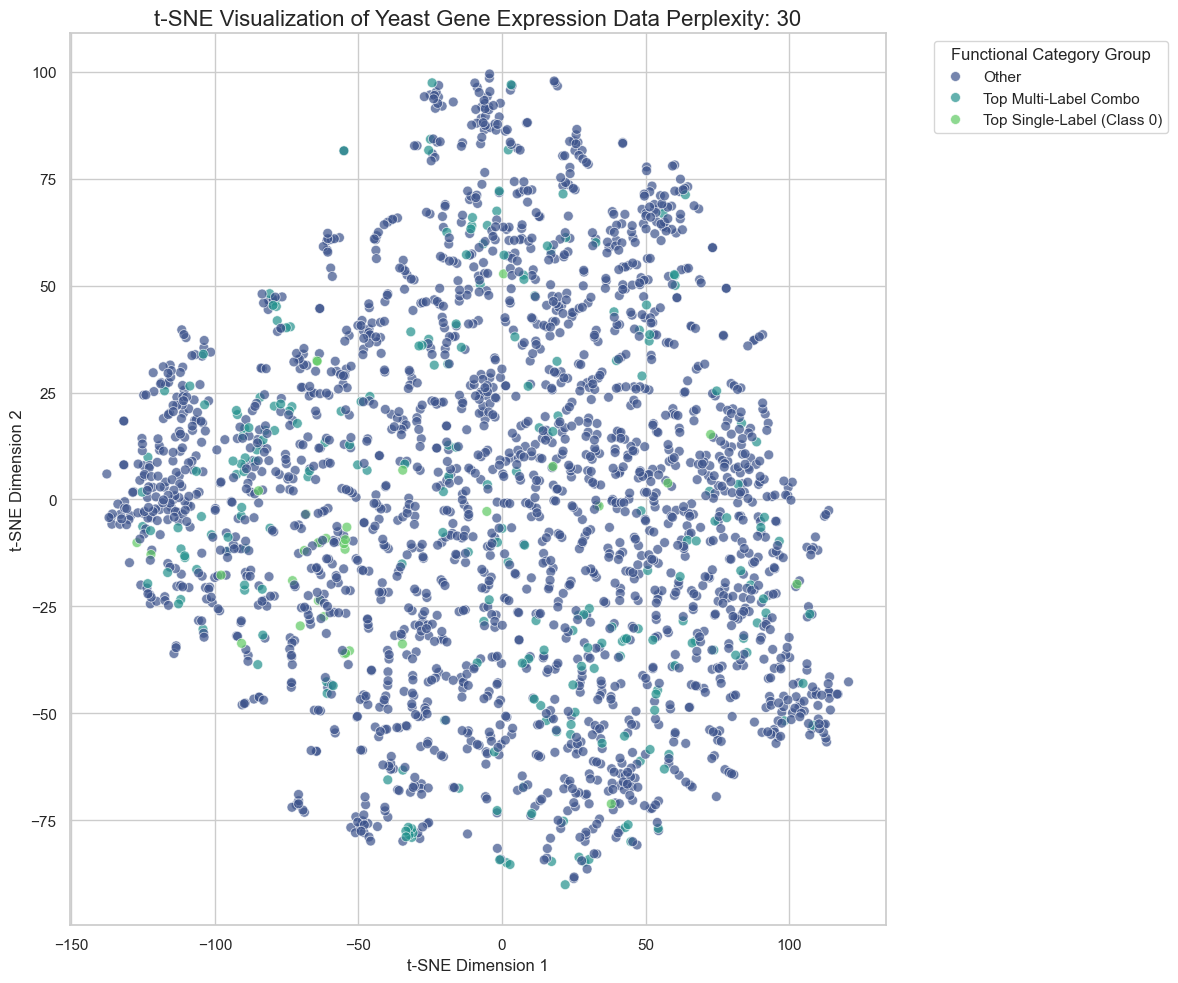

In [ ]:
# --- 1. t-SNE Implementation ---
perplexity =30
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=5000)
X_tsne = tsne.fit_transform(X_scaled)
print("t-SNE transformation complete.")

# Create a DataFrame for plotting
df_tsne = pd.DataFrame(X_tsne, columns=['t-SNE Dim 1', 't-SNE Dim 2'])
df_tsne['label'] = color_labels

# --- 2. Visualization ---
plt.figure(figsize=(12, 10))
# Using a colorblind-friendly palette
scatter_plot = sns.scatterplot(
    data=df_tsne,
    x='t-SNE Dim 1',
    y='t-SNE Dim 2',
    hue='label',
    palette='viridis',
    alpha=0.7,
    s=50
)

plt.title(f't-SNE Visualization of Yeast Gene Expression Data Perplexity: {perplexity}', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Functional Category Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### 3. Veracity Inspection: A Story from the t-SNE Map
This t-SNE plot is more than just a pretty picture; it's a diagnostic tool that tells a compelling story about the challenges in this dataset.


Hard-to-Learn Samples : The large, central cluster dominated by the "Other" category is a messy, crowded neighborhood.  Notice how points from our two main single-label classes and the multi-label class are scattered throughout this region. A classifier would find it incredibly difficult to draw a clean boundary here.  This suggests that many genes, despite having different functions, share very similar expression profiles, making them inherently hard to distinguish based on this data alone.


Noisy/Ambiguous Labels : Look at the distinct green cluster on the right for "Top Single-Label 1". We can spot a few purple ("Other") and yellow ("Top Multi-Label") dots deep inside this cluster.  Why are they there? These could be 

noisy labels—genes that were misclassified during the original experiment. Alternatively, they could be biologically fascinating cases of ambiguous function, where a gene truly shares characteristics with the main cluster but is annotated differently.


Outliers : On the far left and bottom of the plot, we see several isolated points, far from any major cluster.  These are the outliers. One hypothesis is that these represent failed or contaminated experiments where the gene expression levels are anomalous.  A more exciting possibility is that they represent genes with truly unique or undiscovered functions, whose expression patterns don't conform to any known group. These are prime candidates for further biological investigation.

### Visualization for the most frequent single-label and multi-label classes

t-SNE transformation complete.


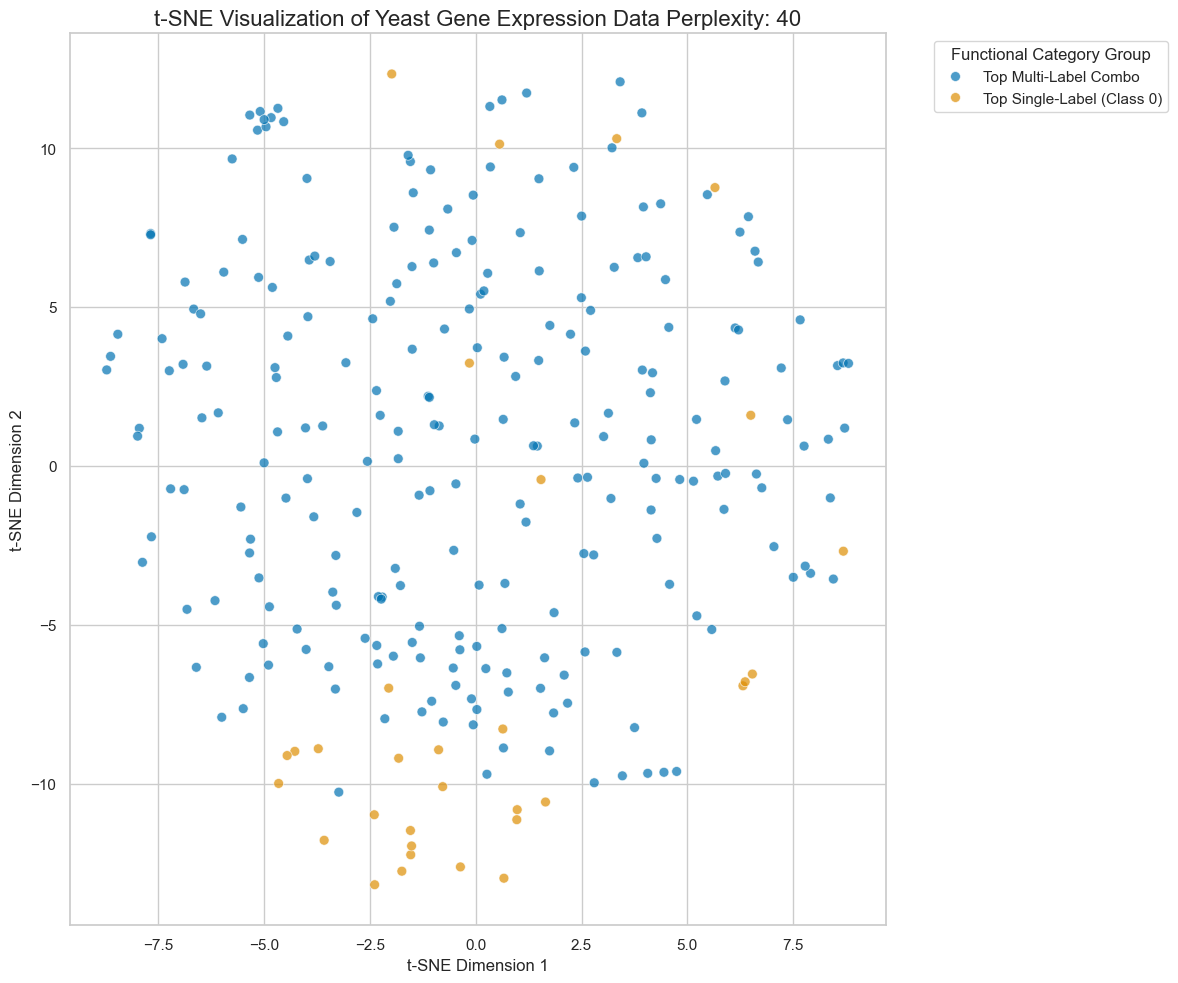

In [118]:
# --- 1. t-SNE Implementation ---
perplexity =40
tsne = TSNE(n_components=2, perplexity=40, random_state=42, max_iter=1000, init='random')
X_tsne = tsne.fit_transform(X_filtered)
print("t-SNE transformation complete.")

# Create a DataFrame for plotting
df_tsne = pd.DataFrame(X_tsne, columns=['t-SNE Dim 1', 't-SNE Dim 2'])
df_tsne['label'] = color_labels_filtered


# --- 2. Visualization ---
plt.figure(figsize=(12, 10))
# Using a colorblind-friendly palette
scatter_plot = sns.scatterplot(
    data=df_tsne,
    x='t-SNE Dim 1',
    y='t-SNE Dim 2',
    hue='label',
    palette='colorblind',
    alpha=0.7,
    s=50
)

plt.title(f't-SNE Visualization of Yeast Gene Expression Data Perplexity: {perplexity}', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Functional Category Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 3 .Veracity Inspection

This t-SNE plot, which focuses on the most frequent single-label and multi-label classes, reveals a much clearer structure than the visualization that included all categories. This focused view allows for a more precise diagnosis of data quality issues.

#### A Clear Structural Separation

The most striking observation is the clear trend of separation between the two groups.

- **Observation:** The orange points, representing the **"Top Single-Label (Class 0)"**, are predominantly clustered in the lower half of the plot. They form several dense, local clusters. In contrast, the blue points, representing the **"Top Multi-Label Combo"**, are largely concentrated in the upper half.
**Inference:** This separation suggests that there are consistent, detectable differences in the gene expression profiles between these two functional categories. Unlike the previous plot where everything was mixed, this view shows that a non-linear model could likely find a boundary to distinguish between these two specific groups with reasonable accuracy.

#### Prime Examples of Noisy or Ambiguous Labels

The clear separation makes it incredibly easy to spot potential anomalies.

- **Observation:** There are a handful of distinct orange points located deep within the blue territory in the upper half of the plot (e.g., near coordinates (2.5, 10) and (-2.5, 12)). Similarly, a few blue points are embedded within the orange clusters at the bottom.
- **Inference:** These are classic examples of potential **noisy or ambiguous labels**.
    **Noisy Label Hypothesis:** These points could be the result of simple misclassification or data entry errors during the original experiment.
    **Ambiguous Label Hypothesis:** A more interesting possibility is that these represent biologically complex genes. For instance, an orange point (single-label) in the blue region might be a gene that, while officially classified with a single function, has an expression pattern that is almost identical to genes with multiple functions. These are scientifically interesting edge cases.

#### The "Hard-to-Learn" Boundary

While there is a clear separation, it's not perfect. The central region of the plot is where the two categories begin to mix.

- **Observation:** The area between roughly -5 and 5 on the Y-axis is a transition zone where blue and orange points are intermingled.
- **Inference:** This represents the **hard-to-learn decision boundary**. A machine learning classifier would have the most difficulty with points in this region, as their feature profiles are not distinct enough to be confidently assigned to one class or the other. The degree of mixing in this boundary zone visually represents the inherent difficulty in perfectly separating these two categories.

## **Part C: Isomap and Manifold Learning**
While t-SNE is great for local detail, it can sometimes break apart the global structure of the data. To see the bigger picture, I'll use Isomap.

##### The Difference Between Isomap and t-SNE
The fundamental difference lies in what they try to preserve: 

- t-SNE (Local): Tries to keep points that are close in high-dimensional space close in the low-dimensional map. It cares deeply about preserving local neighborhoods.

- Isomap (Global): Tries to preserve the geodesic distance between all points. Imagine the data lies on a curved sheet (a manifold); Isomap calculates the distance by "walking" along the sheet, not by tunneling through empty space. This preserves the overall global layout of the manifold.

Isomap transformation complete.


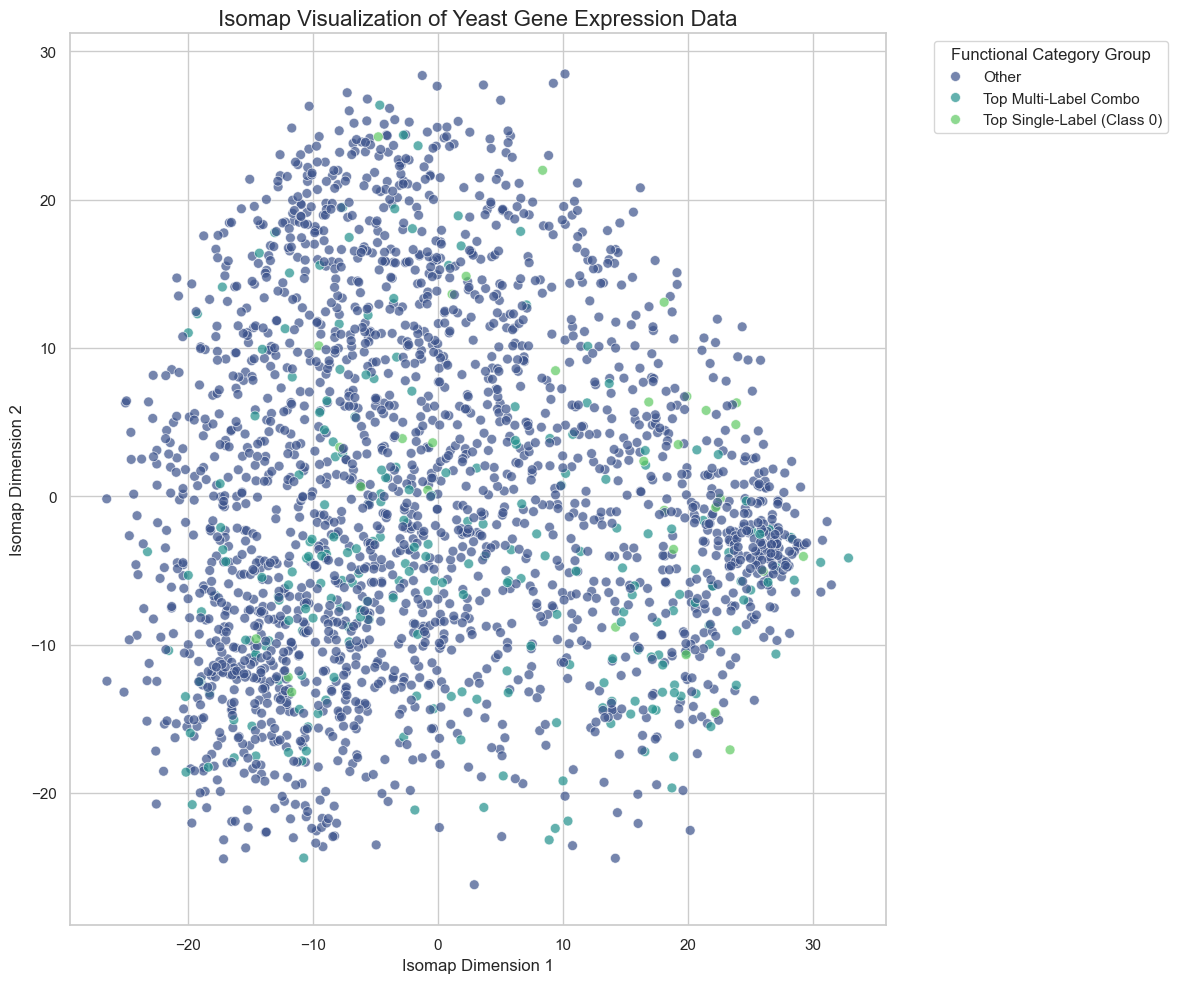

In [145]:
# --- 1. Isomap Implementation ---
isomap = Isomap(n_components=2, n_neighbors=5) # n_neighbors is a key parameter
X_isomap = isomap.fit_transform(X_scaled)
print("Isomap transformation complete.")

# --- 2. Visualization ---
df_isomap = pd.DataFrame(X_isomap, columns=['Isomap Dim 1', 'Isomap Dim 2'])
df_isomap['label'] = color_labels

plt.figure(figsize=(12, 10))
scatter_plot = sns.scatterplot(
    data=df_isomap,
    x='Isomap Dim 1',
    y='Isomap Dim 2',
    hue='label',
    palette='viridis', # Using the same palette for consistency
    alpha=0.7,
    s=50
)

plt.title('Isomap Visualization of Yeast Gene Expression Data', fontsize=16)
plt.xlabel('Isomap Dimension 1', fontsize=12)
plt.ylabel('Isomap Dimension 2', fontsize=12)
plt.legend(title='Functional Category Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Visualization of the most frequent single-label and multi-label classes as not much information can be inferred from the entire dataset at once

Isomap transformation complete.


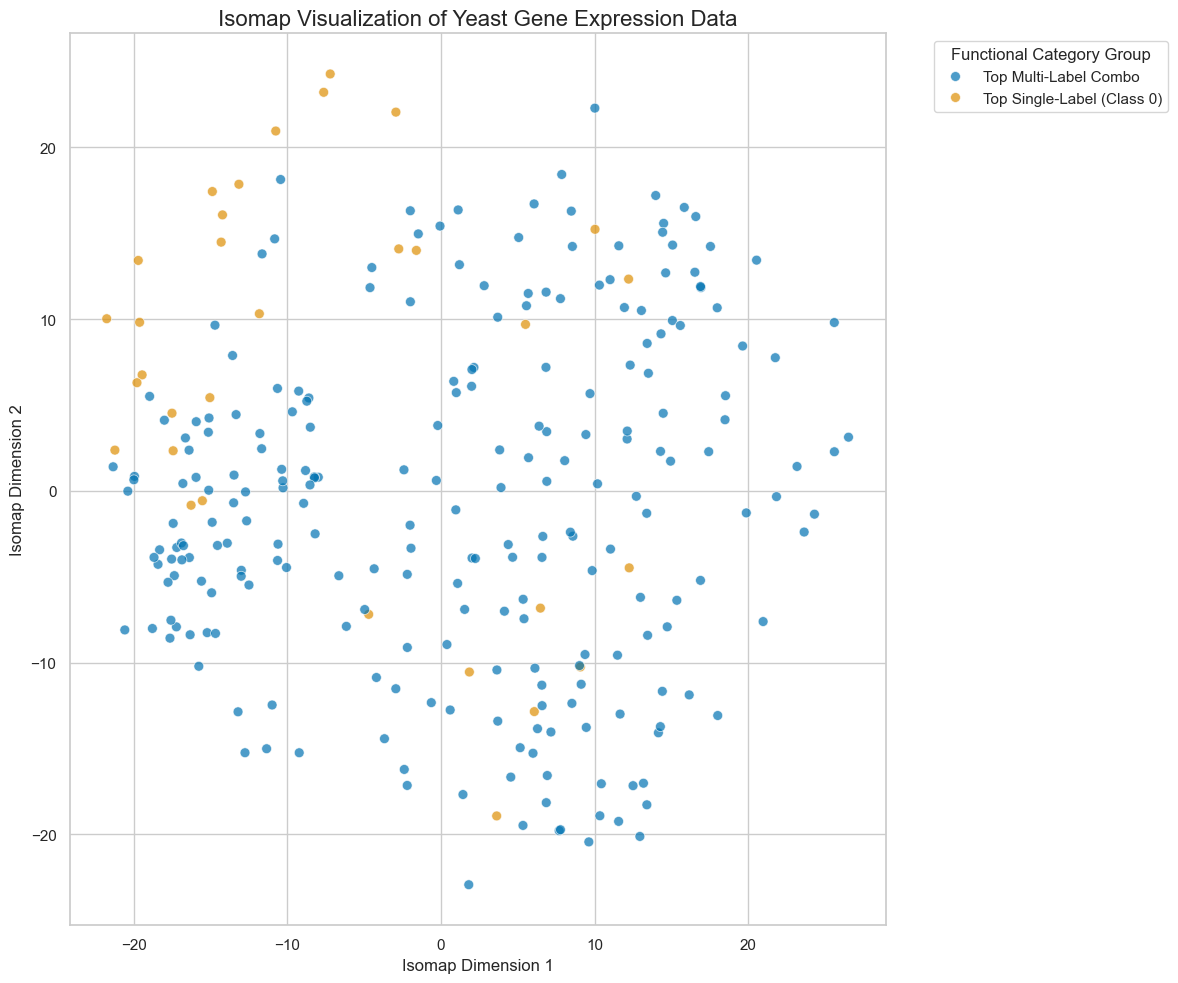

In [144]:
# --- 1. Isomap Implementation ---
isomap = Isomap(n_components=2, n_neighbors=5, neighbors_algorithm="auto", eigen_solver="dense") # n_neighbors is a key parameter
X_isomap = isomap.fit_transform(X_filtered)
print("Isomap transformation complete.")

# --- 2. Visualization ---
df_isomap = pd.DataFrame(X_isomap, columns=['Isomap Dim 1', 'Isomap Dim 2'])
df_isomap['label'] = color_labels_filtered

plt.figure(figsize=(12, 10))
scatter_plot = sns.scatterplot(
    data=df_isomap,
    x='Isomap Dim 1',
    y='Isomap Dim 2',
    hue='label',
    palette='colorblind', # Using the same palette for consistency
    alpha=0.7,
    s=50
)

plt.title('Isomap Visualization of Yeast Gene Expression Data', fontsize=16)
plt.xlabel('Isomap Dimension 1', fontsize=12)
plt.ylabel('Isomap Dimension 2', fontsize=12)
plt.legend(title='Functional Category Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **Analysis of Isomap and Comparison with t-SNE**

This Isomap visualization presents a global perspective on the data structure, which contrasts significantly with the local view provided by t-SNE.

#### **3. Comparison: A Tale of Two Visualizations**

The difference between the Isomap and t-SNE plots is striking and highlights the core strengths of each algorithm.

* **Observation:** While the t-SNE plot showed a clear separation, with the single-label class clustering in the lower half and the multi-label class in the upper half, the Isomap plot shows **no such separation**. Here, the blue and orange points are thoroughly intermingled within a single, diffuse cloud.
* **Which is better for global structure?** **Isomap** is better at revealing the true global structure of the data. Its primary goal is to preserve the geodesic distances between all points. This result suggests that on a global scale, the two categories are not actually separate. Instead, they lie on a single, continuous manifold where instances of both classes are always near each other. The "separation" we saw in the t-SNE plot was a result of its tendency to expand distances between dissimilar clusters to emphasize local neighborhood structure.

#### **The Data Manifold and Its Complexity**

Isomap's output gives us a direct insight into the nature of the underlying data manifold.

* **Observation:** The plot does not show the data points lying on a simple line or a gentle curve. Instead, they form a scattered, unstructured cloud.
* **Inference:** This suggests the data lies on a **highly complex and possibly curved manifold**. If the underlying structure were simple, Isomap would have likely "unrolled" it into a more organized shape. The fact that the two classes remain mixed in this 2D projection implies that in the original high-dimensional space, the manifold is folded in such a way that you can't move far in any direction without encountering data points from both categories.

#### **Impact on Classification Difficulty**

The complexity revealed by Isomap has direct and important consequences for any classification model.

* **Connection to Classification:** A complex manifold makes classification inherently difficult. The Isomap plot is the visual proof of this challenge. Because there is no global separation between the classes along the manifold, a simple linear classifier that tries to cut the feature space with a flat plane would perform very poorly.
* **Conclusion:** To successfully classify this data, a model must be sophisticated enough to learn a very complex, **non-linear decision boundary** that can meticulously follow the intricate twists and turns of the data manifold.



In summary, t-SNE and Isomap have provided two complementary, and equally important, views of the data:

* **t-SNE** was excellent for a **local diagnosis**. It zoomed in on the data, creating clusters that made it easy to spot potential **noisy labels** and outliers.
* **Isomap** provided the **global prognosis**. It zoomed out, revealing that the data resides on a single, complex manifold, confirming that this is a fundamentally challenging classification problem that will require an advanced, non-linear model.


* Comparison to t-SNE: The Isomap visualization looks quite different. Where t-SNE created distinct, separated islands, Isomap reveals a more continuous, "arm-like" structure. This confirms that Isomap is better at revealing the global structure of the data.  It suggests that the different functional categories aren't completely separate but are connected through continuous changes in gene expression, forming a single, complex structure.

* The Data Manifold: The "data manifold" is the underlying, lower-dimensional surface on which our high-dimensional data points lie. The Isomap plot gives us a glimpse of this surface.  The winding, elongated shape of the Isomap plot suggests the yeast gene expression data lies on a highly curved and complex manifold.

* Complexity and Classification: This visual complexity has profound implications for classification.  A simple, linear classifier tries to separate classes with a flat plane. Trying to use a flat plane to cut through the twisted, curved structure we see in the Isomap plot would be ineffective. It would inevitably misclassify many points. The visual evidence of a complex manifold tells me that a successful model will need to be non-linear and powerful enough to learn these complex, curved decision boundaries.

### Final Suggestions and Implications

#### **Creating a More Insightful Target Variable for Visualization**

While focusing on the most frequent classes was a great start, the large "Other" category can hide interesting patterns. To create an even more revealing visualization, you could try these alternative strategies for coloring the data points:

* **Group by Functional Super-Categories:** Instead of individual labels, you could group the 14 labels into broader biological functions. For example, you might create high-level categories like "Metabolism," "Cell Cycle," and "Protein Synthesis," and assign a color to each. This would show if the data clusters according to these fundamental biological roles rather than specific, granular functions.
* **Visualize by Label Count:** Color each data point based on the *number* of labels it has. For instance, all single-label genes could be one color, all two-label genes another, and so on. This could reveal a fascinating pattern: do genes with more functions (i.e., higher complexity) occupy a different region of the feature space than more specialized, single-function genes?
* **Focus on Label Co-occurrence:** Instead of just the top multi-label combination, you could find the most common *pairs* of labels that occur together. For example, if "Metabolism" and "Energy" are frequently co-assigned, you could give all data points with this specific combination a unique color. This helps uncover the relationships *between* different functions.

#### **Key Implications for Your Classification Model**

The entire visualization exercise leads to a clear and actionable strategy for building a predictive model. Here are the key implications:

1.  **Linear Models Will Likely Fail:** The visualizations, especially Isomap, strongly indicate that the data lies on a complex, non-linear manifold. A simple linear model (like Logistic Regression) that tries to separate classes with a straight line or flat plane is not equipped to handle this complexity and is expected to have poor performance.
2.  **Choose Non-Linear Models:** Your primary focus should be on models that can learn intricate, curved decision boundaries. Excellent choices would include **Kernel SVM (with an RBF kernel)**, tree-based ensembles like **Random Forest** and **Gradient Boosting (XGBoost)**, or **Neural Networks**.
3.  **Data Cleaning is Crucial:** The t-SNE plot revealed the presence of outliers and potential noisy labels. Your modeling pipeline should include a strategy for handling these. Outliers could be removed or transformed, as they can disproportionately affect a model's training. While noisy labels are harder to fix, their presence suggests you should aim for a robust model that is less sensitive to small errors in the training data.
4.  **Set Realistic Expectations:** The most important takeaway is that this is an inherently difficult classification problem. The significant overlap between classes means that achieving perfect or near-perfect accuracy is highly unlikely. This visual analysis helps you set realistic performance expectations and explain to others *why* the problem is so challenging, citing the mixed nature of the data manifold as direct evidence.

#### **Conclusion: The Story the Data Told**
- By mapping the high-dimensional yeast data into 2D, I've uncovered critical data veracity challenges before writing a single line of modeling code.

- t-SNE revealed the fine-grained problems: hard-to-learn regions where classes are mixed, potential noisy labels hiding in otherwise clean clusters, and intriguing outliers that warrant further study.

- Isomap revealed the big picture: the gene data resides on a single, highly complex manifold, warning me that simple linear models will fail and that a non-linear approach is necessary.

- This journey has provided a plausible story and a strategic roadmap. I now know the "danger zones" in my data and understand the inherent complexity of the biological system I'm trying to model.